In [1]:
from functions import *
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from time import time
from itertools import tee

In [2]:
def LSNS(data, distances, args=dict(running_time=10, local_search=True)):
    best_solution = (9999999999, None)
    order = random_initial_solution(data)
    order = local_search_steepest(order, distances, data)
    best_order = order
    start = time()
    count = 0
    while(args["running_time"] > time() - start):
        count += 1
        order = destroy(best_order,distances)
        order = repair(order, distances, data) #ten greedy cycle
        assert len(best_order) == len(order), f"Length of best_order is {len(best_order)} but length of order is {len(order)}"
        if args["local_search"]:
            order = local_search_steepest(order, distances, data)
        solution = calculate_value(data, distances, order)
        if solution[0] < best_solution[0]:
            best_solution = solution
            best_order = order
#         best_solution = min((best_solution, calculate_value(data, distances, order)), key = lambda t: t[0])
    return best_solution[0], best_order

In [3]:
def evaluate(func, data, n=20, args=None):
    print(func, args)
    distances = calculate_cost(data)
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    total_time, worst_time, best_time = 0,0,float('inf')
    total_iterations, most_iterations, least_iterations = 0,0,float('inf')
    for _ in tqdm(range(n)):
        start = time()
        (value, solution), iterations = func(data, distances, args)
        elapsed = time() - start
        total_time += elapsed
        if elapsed < best_time:
            best_time = elapsed
        worst_time = max(worst_time, elapsed)


        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)

        total_iterations += iterations
        least_iterations = min(least_iterations, iterations)
        most_iterations = max(most_iterations, iterations)

    return dict(average_score=total / n,
                worst_score=worst_value,
                best_score=best_value,
                solution=np.array(best_solution).T,
                average_time=total_time / n,
                worst_time= worst_time,
                best_time = best_time,
                average_iterations=total_iterations / n,
                most_iterations=most_iterations,
                least_iterations=least_iterations)

In [4]:
def summarize(func, data, title, args):
    evaluation_results = evaluate(func=func,
                                    data=data,
                                     n = 20,
                                     args = args)
    (x, y, z) = evaluation_results["solution"]
    print(f'{title}:')
    print(f'average time: {evaluation_results["average_time"]}\tworst time: {evaluation_results["worst_time"]}\tbest time: {evaluation_results["best_time"]}')
    print(f'average iterations: {evaluation_results["average_iterations"]}\tmost iterations: {evaluation_results["most_iterations"]}\tleast iterations: {evaluation_results["least_iterations"]}')
    print(f'average score: {evaluation_results["average_score"]}\tworst score: {evaluation_results["worst_score"]}\tbest score: {evaluation_results["best_score"]}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], np.full(data[:,0].size, 100), data[:,2], cmap='gray_r')
    plt.clim(0, 1000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()
    return evaluation_results

In [5]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return np.sort(np.array(list(zip(a, b))))

In [6]:
def intersect2d(A, B):
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
           'formats':ncols * [A.dtype]}
    C = np.intersect1d(A.view(dtype), B.view(dtype))
    return C

In [7]:
def similarity(instances, best_solution=None):
    instances = list(zip(*instances))
    scores = np.array(instances[0])
    nodes = np.array(instances[1])
#     print(nodes.shape, scores)
    edges = np.apply_along_axis(pairwise, 1, nodes)
    out = np.zeros((len(scores), 3))
    if best_solution is None:
        for i, (a_node, a_edge) in enumerate(zip(nodes, edges)):
            node_count, edge_count = 0, 0
            for j, (b_node, b_edge) in enumerate(zip(nodes, edges)):
                if i == j:
                    continue
                node_count += len(np.intersect1d(a_node, b_node))
                edge_count += len(intersect2d(a_edge, b_edge))
            out[i] = np.array([scores[i], node_count/(len(nodes)-1), edge_count/(len(edges)-1)])
    else:
        best_nodes = nodes[best_solution]
        best_edges = edges[best_solution]
        for i, (a_node, a_edge) in enumerate(zip(nodes, edges)):
            node_count = len(np.intersect1d(a_node, best_nodes))
            edge_count = len(intersect2d(a_edge, best_edges))
            out[i] = np.array([scores[i], node_count, edge_count])
    np.set_printoptions(suppress=True)
    return out
#     print(len(intersect2d(edges[0],edges[1])))

In [8]:
def summarize_similarity(func, data):
    distances = calculate_cost(data)

    args = dict(running_time=0.05, local_search=False)
    out = [func(data, distances, args) for _ in range(20)]
    best_solution = out.index(max(out, key=lambda x:x[0]))

    title = 'Average'
    x, y1, y2 = similarity(out).T
    plt.scatter(x, y1)
    plt.title(title)
    plt.show()
    plt.scatter(x, y2)
    plt.title(title)
    plt.show()

    title = 'Best'
    x, y1, y2 = similarity(out, best_solution).T
    plt.scatter(x, y1)
    plt.title(title)
    plt.show()
    plt.scatter(x, y2)
    plt.title(title)
    plt.show()

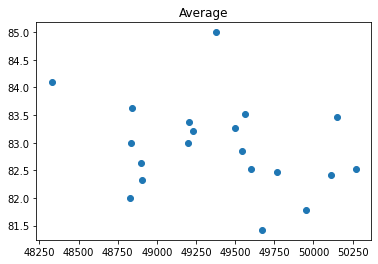

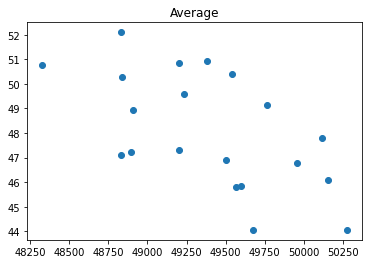

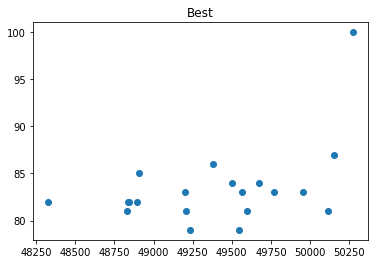

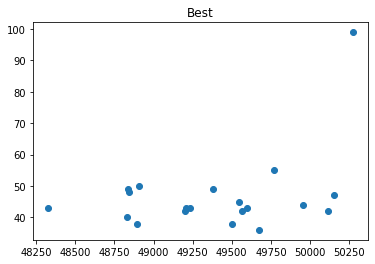

In [9]:
data = np.loadtxt('TSPC.csv', dtype=int, delimiter=';')
summarize_similarity(LSNS, data)

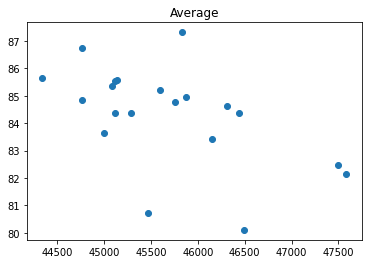

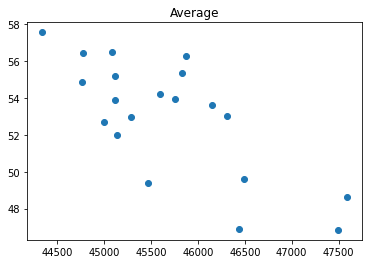

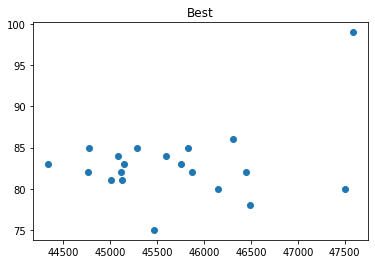

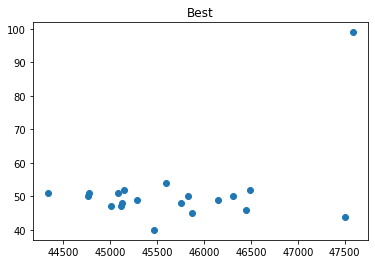

In [11]:
data = np.loadtxt('TSPD.csv', dtype=int, delimiter=';')
summarize_similarity(LSNS, data)